## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/ANN/Challenge
%ls

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/ANN/Challenge
62Percento.ipynb                          requirements.txt
82Percent.ipynb                           ResNet50V2.ipynb
bau.ipynb                                 submission_241118_080033.zip
EfficientNetV2_S.ipynb                    submission_241119_084400.zip
EfficientNetV2_S.keras                    submission_241121_093711.zip
finale_finale.ipynb                       training_set.npz
finale_tea.ipynb                          versione_simo.ipynb
Homework_1_Minimal_Working_Example.ipynb  weights_fine.keras
InceptionV3.ipynb                         weights.keras
MobileNetv3Large.ipynb                    weights_tl_effv2s_2.2.keras
model.png                                 weights_transfer.keras
model.py


## ⚙️ Import Libraries

In [3]:
%%writefile requirements.txt
tensorflow==2.17.0
keras==3.4.1
keras_cv

Overwriting requirements.txt


In [4]:
!pip install -r requirements.txt
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1


In [5]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
import keras as tfk
from keras import layers as tfkl
from keras.layers import Input, Dense, Dropout, Lambda

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow.keras as ker

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

2.17.0
Tensorflow version -> 2.17.0
Keras version -> 3.4.1


In [6]:
class_names = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes',
                 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']
input_shape = (96, 96, 3)

## ⏳ Load Data

In [ ]:
data = np.load('training_set.npz')
X = data['images']
y = data['labels']


## ✂ Split

In [ ]:
# Remove outliers (we know they are a single repeated image at 13700 and 13500)

def remove_images(images, target_image):
    # Filter out images that are equal to target_image using np.array_equal
    out = [y[i] for i in range(len(images)) if not np.array_equal(images[i].flatten(), target_image.flatten())]
    filtered_images = [images[i] for i in range(len(images)) if not np.array_equal(images[i].flatten(), target_image.flatten())]
    return filtered_images, out

X, y = remove_images(X, target_image=X[13700])
X, y = remove_images(X, target_image=X[13500])

X = np.array(X)
y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split

# Separate data by class
# Flatten the y array to 1D before using np.bincount
classes = np.unique(y)
test_samples_per_class = min(np.bincount(y.flatten())) // 5  # Choose a balanced number, like 20% of the minimum class count

X_val, y_val = [], []
X_remaining, y_remaining = [], []

for cls in classes:
    # Get indices of all samples of this class
    cls_indices = np.where(y == cls)[0]
    # Randomly select `test_samples_per_class` indices for the test set
    test_indices = np.random.choice(cls_indices, test_samples_per_class, replace=False)
    # Remaining indices go into the training/validation set
    remaining_indices = np.setdiff1d(cls_indices, test_indices)

    # Add the selected samples to the test set
    X_val.extend(X[test_indices])
    y_val.extend(y[test_indices])

    # Add the remaining samples to the pool for train/validation split
    X_remaining.extend(X[remaining_indices])
    y_remaining.extend(y[remaining_indices])

# Convert lists to arrays
X_val, y_val = np.array(X_val), np.array(y_val)

# X_train, X_test, y_train, y_test = train_test_split(X_remaining,y_remaining, test_size=0.1, random_state=42)

# X_test, y_test = np.array(X_test), np.array(y_test)
X_train, y_train = np.array(X_remaining), np.array(y_remaining)

# Now split the remaining data into training and validation sets
del X_remaining, y_remaining, X, y

# Print the shapes of the split data to verify
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")

Training data shape: (10607, 96, 96, 3)
Validation data shape: (1352, 96, 96, 3)
Training labels shape: (10607, 1)
Validation labels shape: (1352, 1)


## ⏫ Oversampling

In [ ]:
# Find the maximum class count to balance all classes to this count
target_count = int(max(pd.Series(y_train.flatten()).value_counts()) * 4)

# Initialize the balanced training dataset without augmentation
X_train_balanced = []
y_train_balanced = []

# Balance each class in the training set
for label in np.unique(y_train):
    # Extract samples for this class
    X_class = X_train[y_train.flatten() == label]

    # Calculate how many samples are needed to reach the target count
    num_to_generate = target_count - X_class.shape[0]

    # Add the original images to the balanced training dataset
    X_train_balanced.extend(X_class)
    y_train_balanced.extend([label] * X_class.shape[0])

    # If we need more samples, replicate existing images without augmentation
    if num_to_generate > 0:
        # Randomly replicate images to reach the target count
        replicated_images = np.random.choice(range(len(X_class)), num_to_generate)
        X_train_balanced.extend(X_class[replicated_images])
        y_train_balanced.extend([label] * num_to_generate)

# Convert lists to arrays
X_train = np.array(X_train_balanced)
y_train = np.array(y_train_balanced)

# Display dataset sizes

print("Balanced training set size:", X_train.shape)
print("Validation set size:", X_val.shape)

# Set input shape and output shape for the model
input_shape = X_train.shape[1:]
output_shape = len(np.unique(y_train))  # Number of classes in the output


Balanced training set size: (69152, 96, 96, 3)
Validation set size: (1352, 96, 96, 3)


## 🔎 Inspect Data

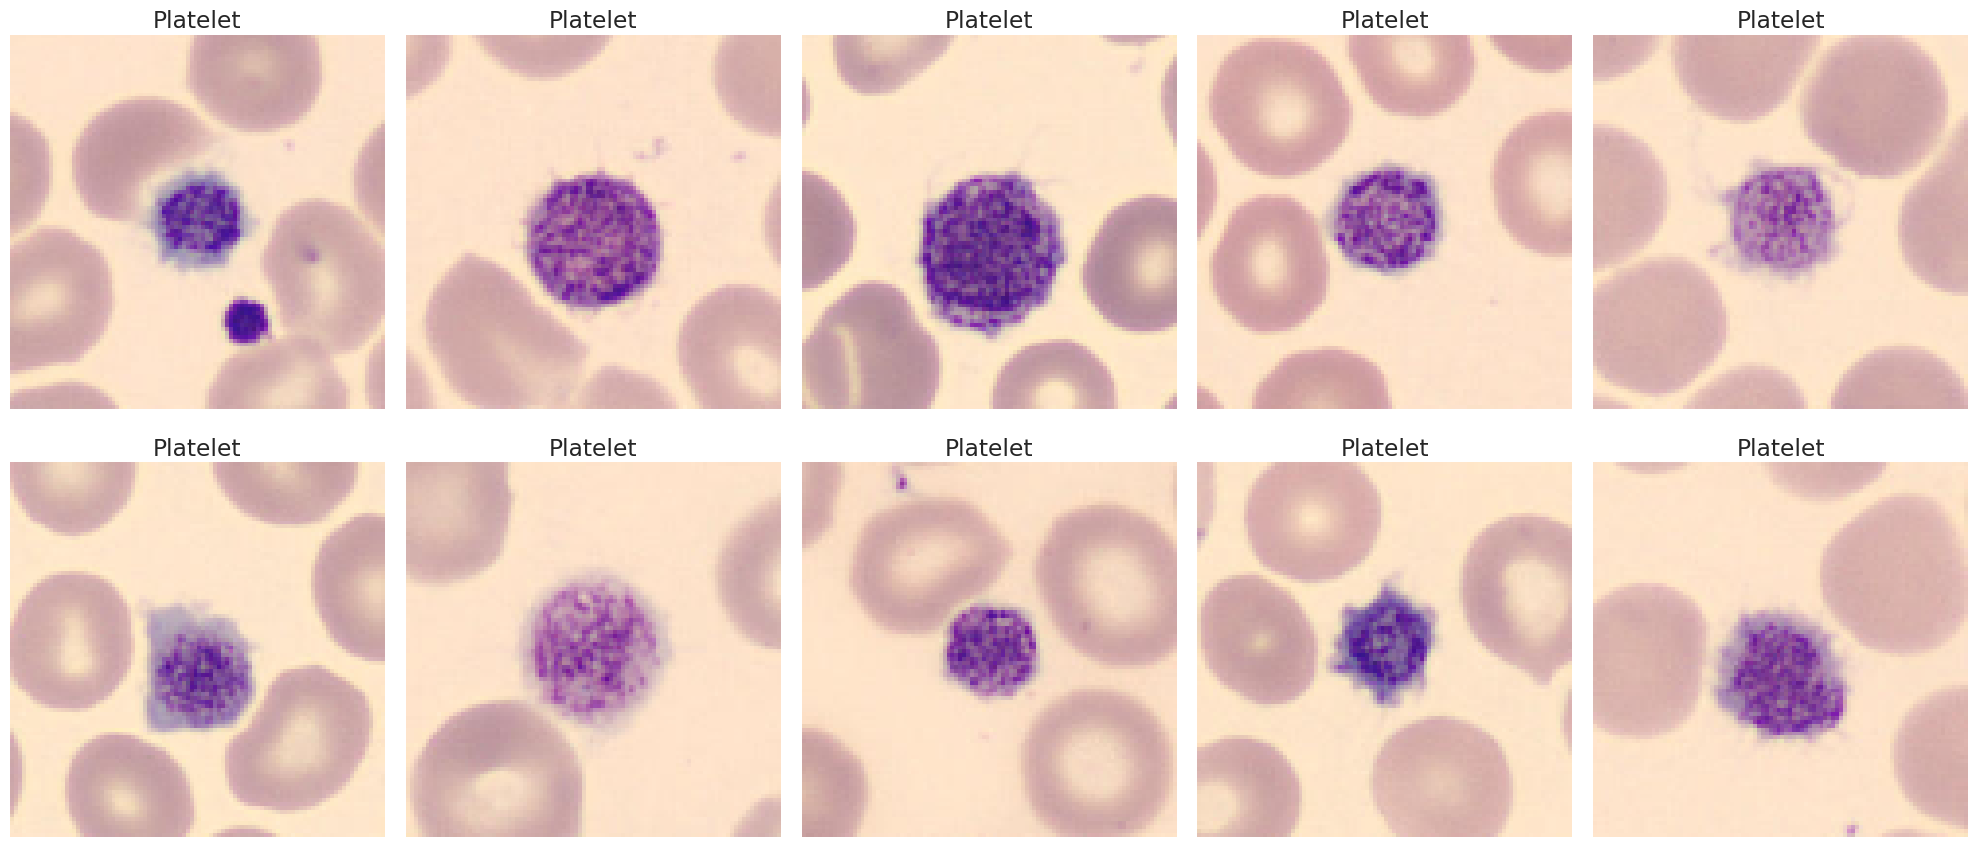

In [ ]:
# Number of images to display
num_img = 10
numClass = 7  # Set this to an integer (0 to 7) to filter by a specific class

# Filter images based on the selected class if numClass is set
if numClass is not None:
    indices = [i for i, label in enumerate(y_train) if label == numClass]
else:
    indices = range(len(X_train))

# Select random indices from the filtered set
random_indices = random.sample(indices, num_img)

# Create subplot layout for images
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))

for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]

    # Display the image at the selected index
    ax.imshow(X_train[idx] / 255)

    # Add class name as title, formatting it to replace underscores with spaces and capitalize
    class_name = class_names[y_train[idx]]
    class_name = class_name.replace('_', ' ').title()
    ax.set_title(class_name, pad=5)

    # Remove axis lines for clearer display
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## ⭐ Custom augmentation

In [ ]:
!pip install keras.preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.3 MB/s eta 0:00:00


In [ ]:
num_classes = 8
# Define class-specific augmentation functions
def augment_for_class_0(): #Basophil
    return ker.preprocessing.image.ImageDataGenerator(
    zoom_range=[0.8, 1.2],
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'  # Use nearest neighbor for filling edges
)

def augment_for_class_1():
    return ker.preprocessing.image.ImageDataGenerator(
      zoom_range=[0.85, 1.15],
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=3,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest'  # Fill with nearest pixels to handle edges
  )

def augment_for_class_2():
    return ker.preprocessing.image.ImageDataGenerator(
    zoom_range=[0.9, 1.2],
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=3,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'  # Fill any empty space with nearest pixel values
)


def augment_for_class_3():
    return ker.preprocessing.image.ImageDataGenerator(
    zoom_range=[0.85, 1.15],
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=5,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'  # Fill any empty space with nearest pixel values
)


def augment_for_class_4():
    return ker.preprocessing.image.ImageDataGenerator(
    zoom_range=[0.9, 1.1],
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'  # Fill any empty space with nearest pixel values
)

def augment_for_class_5():
    return ker.preprocessing.image.ImageDataGenerator(
    zoom_range=[0.85, 1.15],
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'  # Fill any empty space with nearest pixel values
)


def augment_for_class_6():
    return ker.preprocessing.image.ImageDataGenerator(
    zoom_range=[0.9, 1.1],
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'  # Fill any empty space with nearest pixel values
)

def augment_for_class_7():
    return ker.preprocessing.image.ImageDataGenerator(
    zoom_range=[0.95, 1.1],
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'  # Fill any empty space with nearest pixel values
)

# Class-specific augmentation function
def label_based_augmentation(label):
    if label == 0:
        return augment_for_class_0()
    elif label == 1:
        return augment_for_class_1()
    elif label == 2:
        return augment_for_class_2()
    elif label == 3:
        return augment_for_class_3()
    elif label == 4:
        return augment_for_class_4()
    elif label == 5:
        return augment_for_class_5()
    elif label == 6:
        return augment_for_class_6()
    elif label == 7:
        return augment_for_class_7()
    else:
        raise ValueError(f"Unknown label: {label}")


Apply augmentation

In [ ]:
augmented_images = []  # Create an empty list to store augmented images
augmented_labels = []  # Create an empty list to store augmented labels

for i, img in enumerate(X_train):  # Get index and image using enumerate
    img = img.reshape((1,) + img.shape)  # Reshape to (1, height, width, channels)
    for aug_img in label_based_augmentation(y_train[i]).flow(img, batch_size=1):
        augmented_images.append(aug_img[0])  # Get the augmented image
        augmented_labels.append(y_train[i])  # Store the corresponding label
        break  # Take one augmented version per image

# Convert the lists back to numpy arrays
X_train = np.array(augmented_images)
y_train = np.array(augmented_labels)

# Print the new shapes of the datasets
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")


New X_train shape: (69152, 96, 96, 3)
New y_train shape: (69152,)


Augmentation Pipeline

In [ ]:
import keras_cv  # Ensure Keras-CV is installed: `pip install keras-cv`

# Define the augmentation pipeline with only AugMix and RandAugment
def create_simplified_augmentation_pipeline():
    return tf.keras.Sequential([
        keras_cv.layers.AugMix(value_range=(0, 255), severity=0.3, alpha=1.0),  # AugMix
        keras_cv.layers.RandAugment(value_range=(0, 255), augmentations_per_image=2, magnitude=0.5)  # RandAugment
    ])

# Apply augmentation to the dataset and return augmented arrays
def augment_dataset_to_array(X_train, y_train, batch_size=32):
    aug_pipeline = create_simplified_augmentation_pipeline()

    # Create a tf.data.Dataset from the input arrays
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    # Shuffle, batch, and apply the augmentation pipeline
    dataset = (dataset
               .shuffle(buffer_size=len(X_train))
               .batch(batch_size)
               .map(lambda x, y: (aug_pipeline(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
               .prefetch(tf.data.AUTOTUNE))

    # Collect augmented data
    augmented_images = []
    augmented_labels = []
    for images, labels in dataset:
        augmented_images.append(images.numpy())
        augmented_labels.append(labels.numpy())

    # Concatenate batches to form final arrays
    return np.concatenate(augmented_images, axis=0), np.concatenate(augmented_labels, axis=0)

# Assuming X_train and y_train are defined and contain your data
X_train, y_train = augment_dataset_to_array(X_train, y_train, batch_size=32)

# Now X_train and y_train contain the augmented data
print(f"Augmented X_train shape: {X_train.shape}")
print(f"Augmented y_train shape: {y_train.shape}")


Augmented X_train shape: (69152, 96, 96, 3)
Augmented y_train shape: (69152,)


## 🔎 Inspect Data

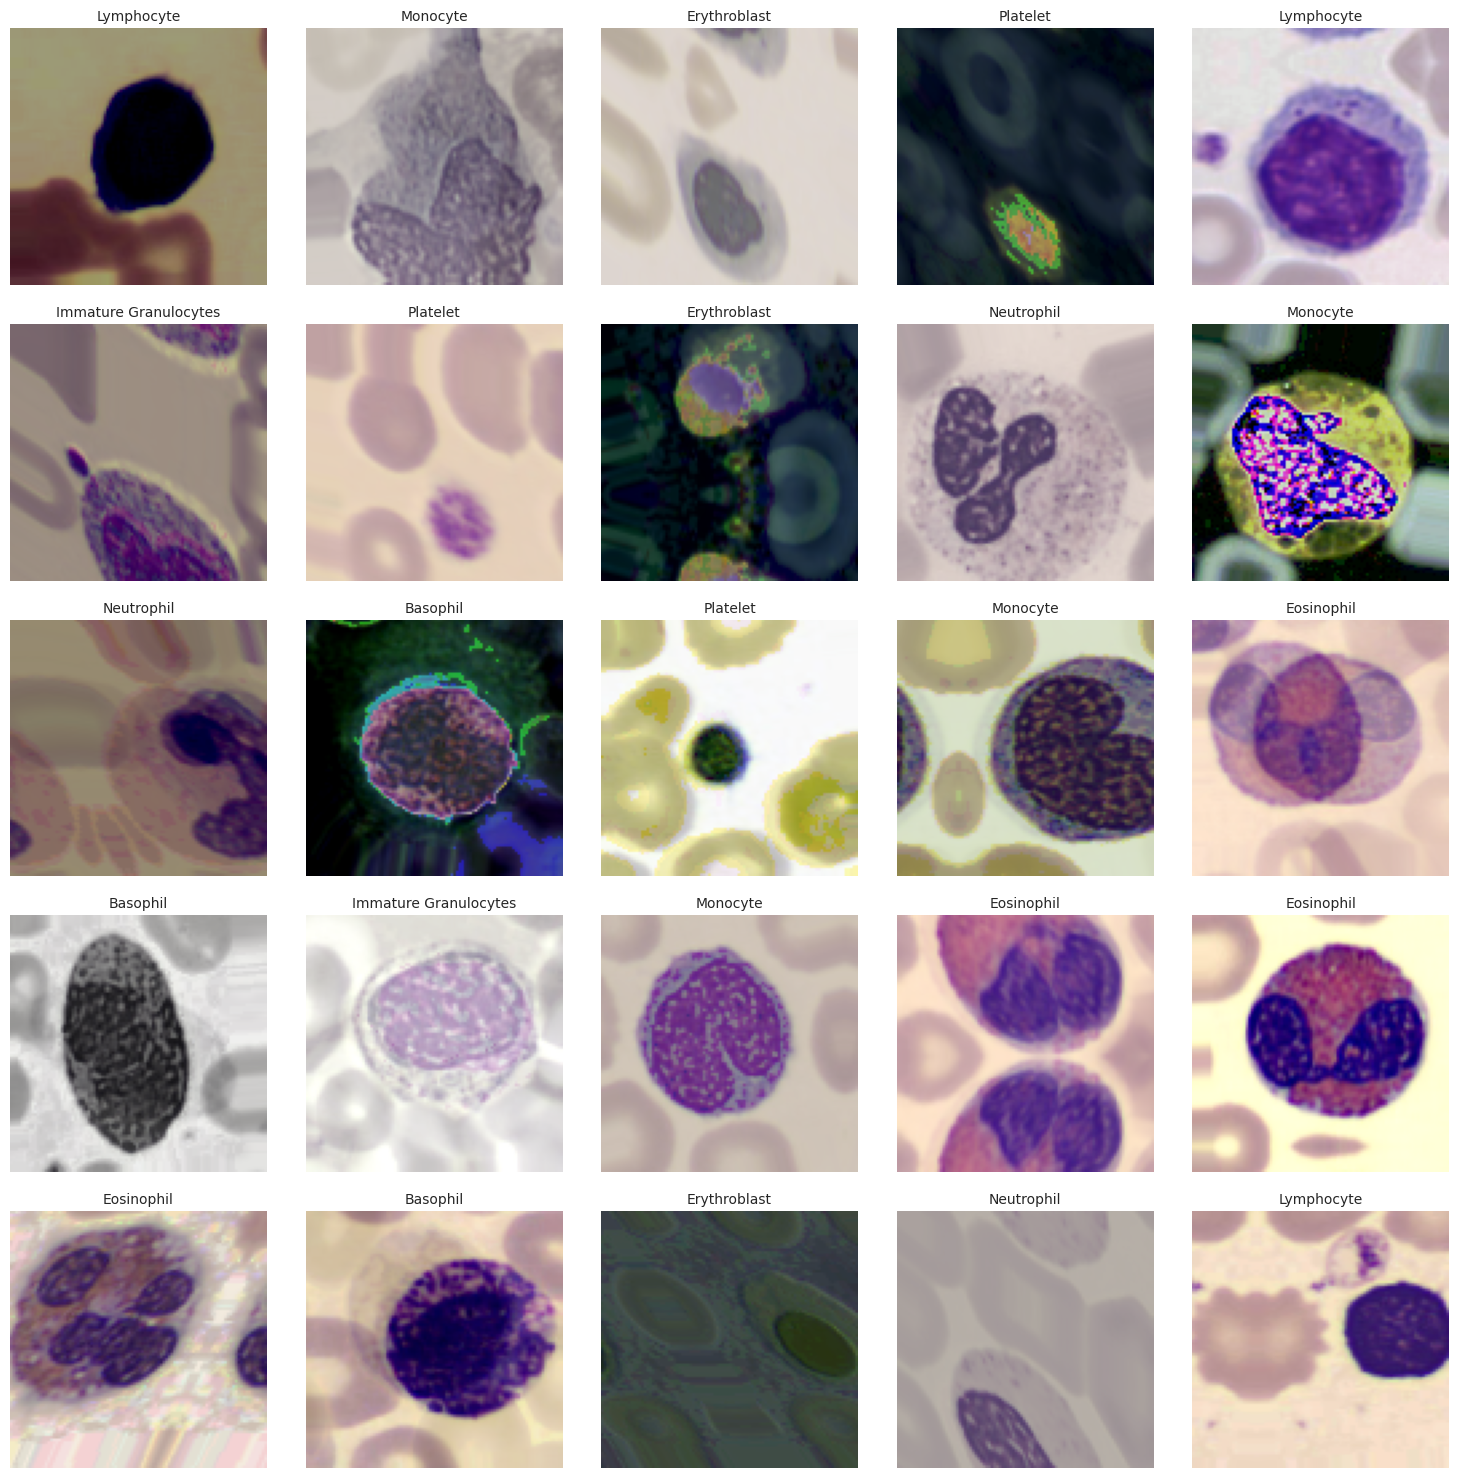

In [ ]:
import random
import matplotlib.pyplot as plt

# Number of images to display
num_img = 25  # 5 rows * 5 columns

# Select random indices from the training set
random_indices = random.sample(range(len(X_train)), num_img)

# Create subplot layout for images
fig, axes = plt.subplots(5, 5, figsize=(15, 15))  # 5 rows, 5 columns

for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]  # Adjust row and column indexing for 5x5 grid

    # Display the image at the selected index
    ax.imshow(X_train[idx] / 255)

    # Add class name as title, formatting it to replace underscores with spaces and capitalize
    class_name = class_names[y_train[idx]]
    class_name = class_name.replace('_', ' ').title()
    ax.set_title(class_name, pad=5, fontsize=10)  # Adjust font size for better fit

    # Remove axis lines for clearer display
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

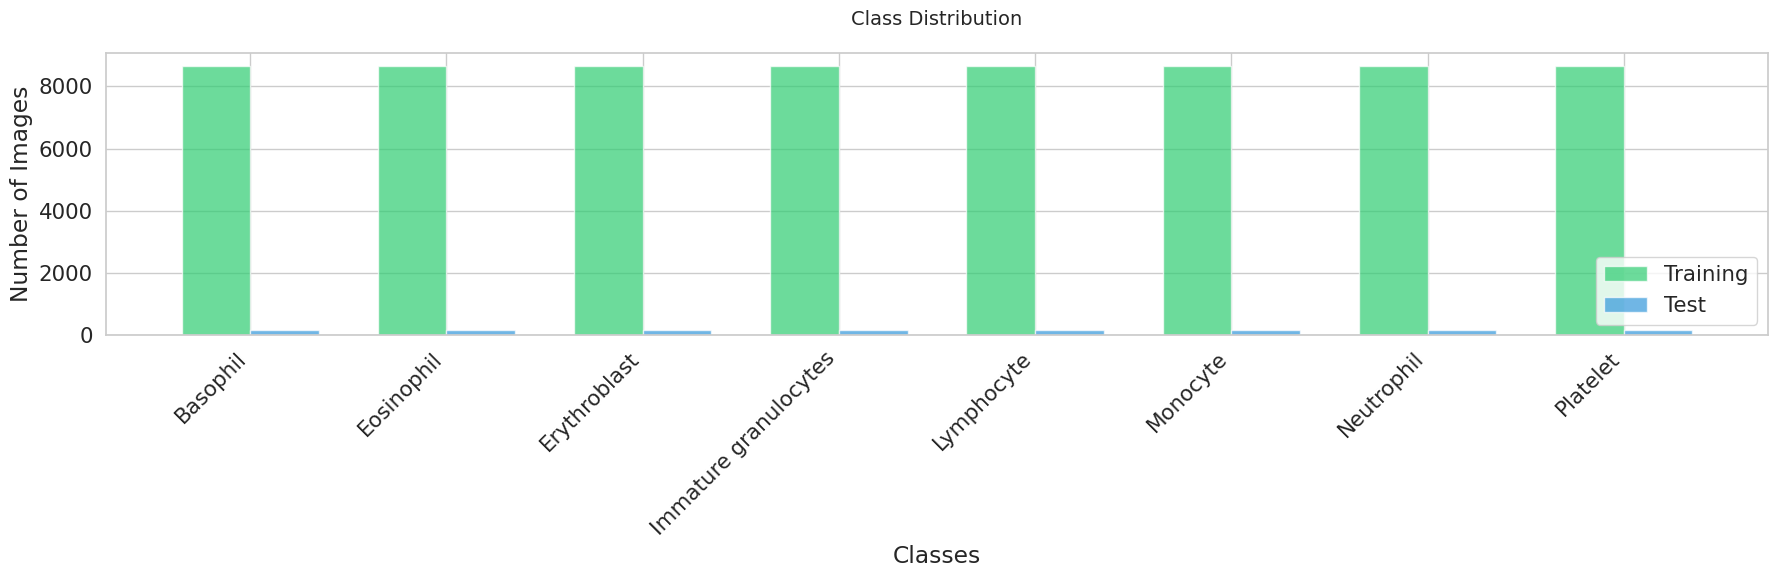

In [ ]:
def plot_class_distribution(y_train, y_test, class_names):
    # Set seaborn style for the plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(18, 6))

    # Calculate class distributions for training and test sets
    # Flatten y_train and y_test to 1D arrays before using np.bincount
    train_dist = np.bincount(y_train.ravel()) # Flatten y_train to 1D
    test_dist = np.bincount(y_test.ravel())   # Flatten y_test to 1D

    # Create x positions and set bar width
    x = np.arange(len(class_names))
    width = 0.35

    # Plot bars for training and test distributions
    plt.bar(x - width / 2, train_dist, width, label='Training', color='#2ecc71', alpha=0.7)
    plt.bar(x + width / 2, test_dist, width, label='Test', color='#3498db', alpha=0.7)

    # Customise plot title and labels
    plt.title('Class Distribution', pad=20, fontsize=14)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')

    # Set class names as x-axis labels with rotation
    plt.xticks(x, class_names, rotation=45, ha='right')

    # Add legend for training and test distributions
    plt.legend(loc='lower right')

    # Adjust layout for optimal spacing
    plt.tight_layout()
    plt.show()

# Execute function to plot class distribution
plot_class_distribution(y_train, y_val, class_names)

## Transfer Learning

In [7]:
inputs = tf.keras.Input(shape=input_shape, name='input_layer')

efficientnet = tf.keras.applications.EfficientNetV2S(
        include_top=False, weights='imagenet', input_tensor=inputs
    )

# Freeze all layers
efficientnet.trainable = False

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import keras_cv
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2

def build_model(num_classes):
    # Define input layer

    # EfficientNetV2-B3 as feature extractor

    x = efficientnet(inputs, training=False)  # Freeze pre-trained layers during initial training

    # Global pooling
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)

    # Stochastic Depth (Regularization)
    x = layers.Dropout(0.3, name='stochastic_depth')(x)

    # First dense layer with L2 regularization
    x = layers.Dense(
        256,
        activation='swish',
        kernel_regularizer=l2(0.0005),
        kernel_initializer='he_normal',
        name='dense1'
    )(x)

    # Group Normalization
    x = layers.GroupNormalization(groups=8, name='group_norm')(x)

    # Second dense layer
    x = layers.Dense(
        128,
        activation='swish',
        kernel_regularizer=l2(0.0005),
        kernel_initializer='he_normal',
        name='dense2'
    )(x)

    # Dropout for regularization
    x = layers.Dropout(0.5, name='dropout2')(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)

    # Define the complete model linking input and output
    model = Model(inputs=inputs, outputs=outputs, name='improved_model')

    # Compile with AdamW optimizer and learning rate schedule
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=0.001, weight_decay=1e-4
    )

    # Compile the model
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

# Learning rate scheduler (Cosine Decay)
def lr_scheduler(epoch, lr):
    initial_lr = 0.001
    return initial_lr * tf.math.cos((epoch / 50) * (3.14 / 2))

# Callback for the learning rate scheduler
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [9]:
#------BUILD MODEL--------
tl_model = build_model(8)
#------------------------

# Display a summary of the model architecture
tl_model.summary(expand_nested=True, show_trainable=True)

# Display model architecture with layer shapes and trainable parameters
#tfk.utils.plot_model(tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "improved_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ efficientnetv2-s (Functional)       │ (None, 3, 3, 1280)           │    20,331,360 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ input_layer (InputLayer)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ rescaling (Rescaling)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_conv (Conv2D)             │ (None, 48, 48, 24)           │           648 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_bn (BatchNormalization)   │ (None, 48, 48, 24)           │            96 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_activation (Activation)   │ (None, 48, 48, 24)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_project_conv (Conv2D)  │ (None, 48, 48, 24)           │         5,184 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_project_bn             │ (None, 48, 48, 24)           │            96 │    N    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_project_activation     │ (None, 48, 48, 24)           │             0 │    -    │
│ (Activation)                        │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_add (Add)              │ (None, 48, 48, 24)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1b_project_conv (Conv2D)  │ (None, 48, 48, 24)           │         5,184 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1b_project_bn             │ (None, 48, 48, 24)           │            96 │    N    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1b_project_activation     │ (None, 48, 48, 24)           │             0 │    -    │
│ (Activation)                        │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1b_drop (Dropout)         │ (None, 48, 48, 24)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1b_add (Add)              │ (None, 48, 48, 24)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block2a_expand_conv (Conv2D)   │ (None, 24, 24, 96)           │        20,736 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block2a_expand_b

 Total params: 20,693,736 (78.94 MB)

 Trainable params: 362,376 (1.38 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [ ]:
# Train the model
tl_history = tl_model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'weights.keras'
tl_model.save(model_filename)

# Free memory by deleting the model instance
del tl_model

Epoch 1/200
531/531 ━━━━━━━━━━━━━━━━━━━━ 68s 115ms/step - accuracy: 0.2041 - loss: 2.3279 - val_accuracy: 0.4822 - val_loss: 1.6529
Epoch 2/200
531/531 ━━━━━━━━━━━━━━━━━━━━ 58s 108ms/step - accuracy: 0.2764 - loss: 1.9908 - val_accuracy: 0.4786 - val_loss: 1.5233
Epoch 3/200
531/531 ━━━━━━━━━━━━━━━━━━━━ 58s 109ms/step - accuracy: 0.2866 - loss: 1.9212 - val_accuracy: 0.4800 - val_loss: 1.4993
Epoch 4/200
531/531 ━━━━━━━━━━━━━━━━━━━━ 58s 109ms/step - accuracy: 0.2945 - loss: 1.8799 - val_accuracy: 0.5259 - val_loss: 1.4124
Epoch 5/200
531/531 ━━━━━━━━━━━━━━━━━━━━ 58s 109ms/step - accuracy: 0.2978 - loss: 1.8563 - val_accuracy: 0.5096 - val_loss: 1.4272
Epoch 6/200
531/531 ━━━━━━━━━━━━━━━━━━━━ 58s 109ms/step - accuracy: 0.3042 - loss: 1.8357 - val_accuracy: 0.5000 - val_loss: 1.4218
Epoch 7/200
531/531 ━━━━━━━━━━━━━━━━━━━━ 58s 109ms/step - accuracy: 0.3081 - loss: 1.8230 - val_accuracy: 0.5096 - val_loss: 1.4317
Epoch 8/200
531/531 ━━━━━━━━━━━━━━━━━━━━ 58s 109ms/step - accuracy: 0.3121 -

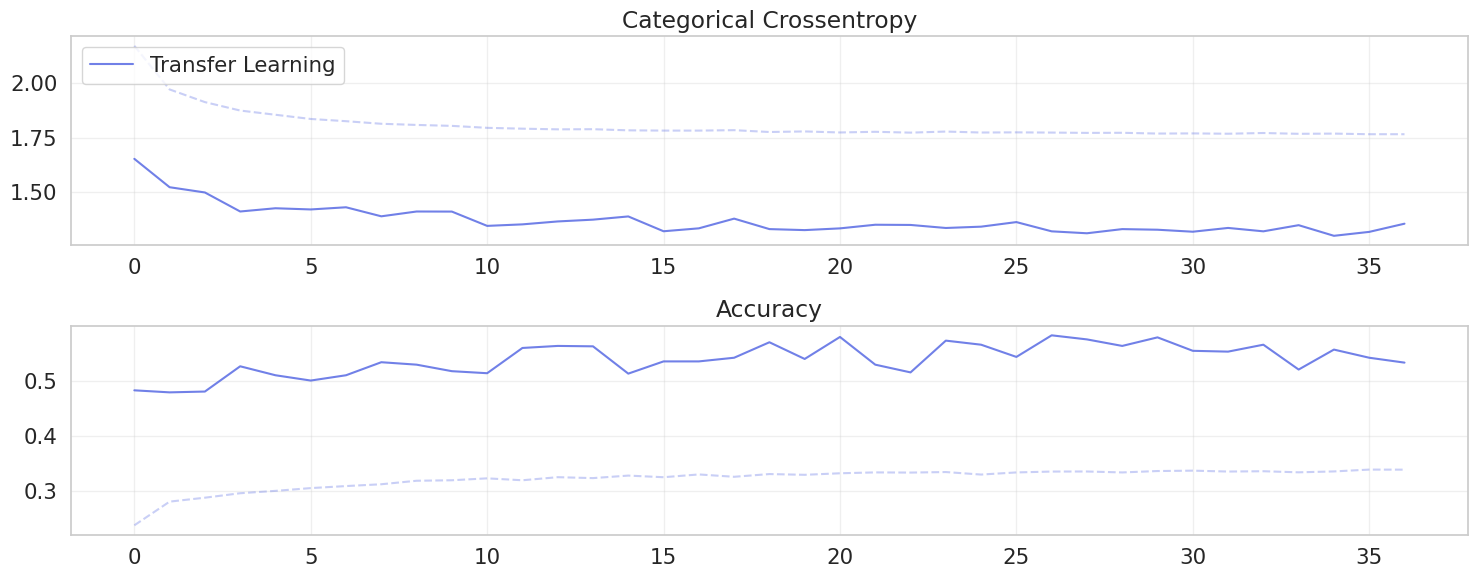

In [ ]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot loss for both re-trained and transfer learning models
ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both re-trained and transfer learning models
ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.set_title('Accuracy')
ax2.grid(alpha=0.3)

# Adjust layout to prevent label overlap and display the plots
plt.tight_layout()
plt.show()

## Fine tuning

In [ ]:
# Callback for the learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=10000,
    decay_rate=0.9
)

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('weights.keras') # weights_tl_effv2s_2.2
ft_model.get_layer('efficientnetv2-s').trainable = True
ft_model.training=False
ft_model.compile(loss=tfk.losses.SparseCategoricalCrossentropy(), optimizer=tfk.optimizers.Lion(learning_rate=lr_schedule), metrics=['accuracy'])

In [ ]:
ft_model.summary(expand_nested=True, show_trainable=True)

Model: "improved_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ efficientnetv2-s (Functional)       │ (None, 3, 3, 1280)           │    20,331,360 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ input_layer (InputLayer)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ rescaling (Rescaling)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_conv (Conv2D)             │ (None, 48, 48, 24)           │           648 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_bn (BatchNormalization)   │ (None, 48, 48, 24)           │            96 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_activation (Activation)   │ (None, 48, 48, 24)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_project_conv (Conv2D)  │ (None, 48, 48, 24)           │         5,184 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_project_bn             │ (None, 48, 48, 24)           │            96 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_project_activation     │ (None, 48, 48, 24)           │             0 │    -    │
│ (Activation)                        │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_add (Add)              │ (None, 48, 48, 24)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1b_project_conv (Conv2D)  │ (None, 48, 48, 24)           │         5,184 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1b_project_bn             │ (None, 48, 48, 24)           │            96 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1b_project_activation     │ (None, 48, 48, 24)           │             0 │    -    │
│ (Activation)                        │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1b_drop (Dropout)         │ (None, 48, 48, 24)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1b_add (Add)              │ (None, 48, 48, 24)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block2a_expand_conv (Conv2D)   │ (None, 24, 24, 96)           │        20,736 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block2a_expand_b

 Total params: 20,693,736 (78.94 MB)

 Trainable params: 20,539,864 (78.35 MB)

 Non-trainable params: 153,872 (601.06 KB)

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 4,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=2, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'weights.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/4
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 1333s 1s/step - accuracy: 0.9195 - loss: 0.3385 - val_accuracy: 0.9852 - val_loss: 0.1017
Epoch 2/4
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 1284s 1s/step - accuracy: 0.9660 - loss: 0.1626 - val_accuracy: 0.9845 - val_loss: 0.1041
Epoch 3/4
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 1271s 1s/step - accuracy: 0.9843 - loss: 0.0974 - val_accuracy: 0.9845 - val_loss: 0.1006
Final validation accuracy: 98.52%


## 🧮 Compute Metrics


In [ ]:
# Load the saved model
model = tfk.models.load_model('EfficientNetV2_S.keras')

In [ ]:
data = np.load('training_set.npz')
X = data['images']
y = data['labels']

class_names = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes',
                 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

In [ ]:
# Remove outliers (we know they are a single repeated image at 13700 and 13500)

def remove_images(images, target_image):
    # Filter out images that are equal to target_image using np.array_equal
    out = [y[i] for i in range(len(images)) if not np.array_equal(images[i].flatten(), target_image.flatten())]
    filtered_images = [images[i] for i in range(len(images)) if not np.array_equal(images[i].flatten(), target_image.flatten())]
    return filtered_images, out

X, y = remove_images(X, target_image=X[13700])
X, y = remove_images(X, target_image=X[13500])

X = np.array(X)
y = np.array(y)

              precision    recall  f1-score   support

           0     0.9930    0.9953    0.9941       852
           1     1.0000    0.9972    0.9986      2181
           2     0.9981    0.9871    0.9926      1085
           3     0.9679    0.9837    0.9758      2026
           4     0.9747    0.9965    0.9854       849
           5     0.9772    0.9909    0.9840       993
           6     0.9939    0.9730    0.9833      2330
           7     0.9994    0.9988    0.9991      1643

    accuracy                         0.9888     11959
   macro avg     0.9880    0.9903    0.9891     11959
weighted avg     0.9889    0.9888    0.9888     11959



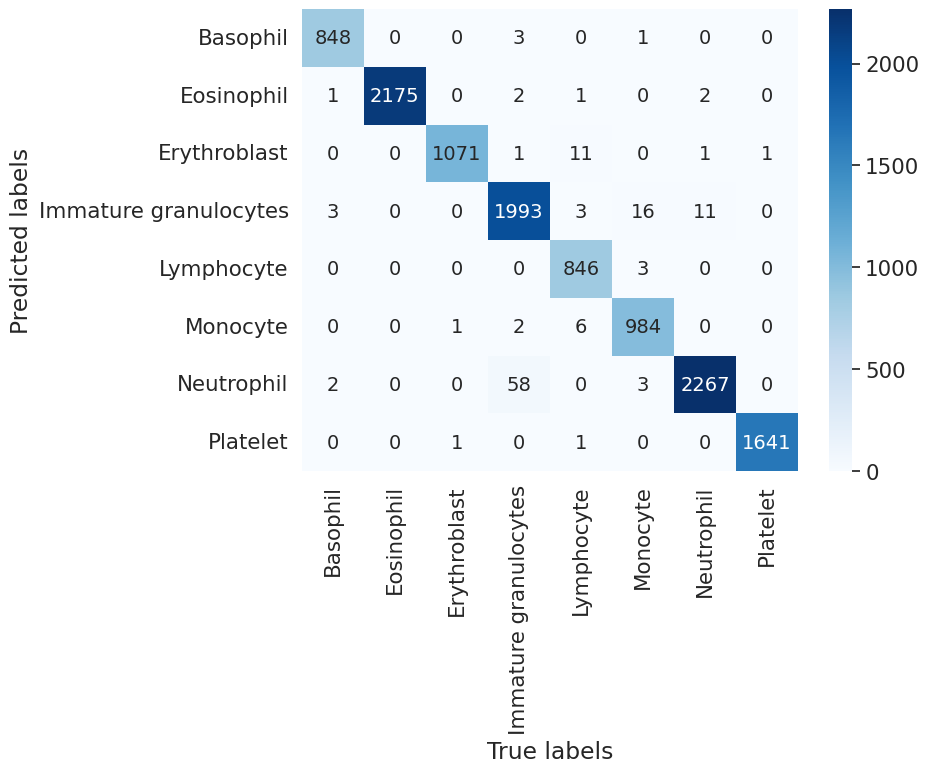

In [ ]:
## Since we do not have a test set (to provide more parameters for trainig) we'll evaluate the model's performance on the whole dataset (without outliers)

from sklearn.metrics import classification_report, confusion_matrix
# Predict class probabilities and get predicted classes
preds = model.predict(X, verbose=0)
preds = np.argmax(preds, axis=-1)

# Extract ground truth classes
dataset_gt = y.flatten()

# Compute all metrics, we really only care about 'macro avg' results because class size is not taken into account
report = classification_report(dataset_gt, preds, digits=4)
print(report)

# Compute the confusion matrix
cm = confusion_matrix(dataset_gt, preds)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## 📊 Prepare Your Submission


To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 56%)
  adding: weights.keras (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>